In [27]:
import numpy as np
import matplotlib.pyplot as plt # data visualization library
import scipy

If possible, update your sklearn version to 1.3.2 to reduce variance in the versions.

In [28]:
#!pip3 install scikit-learn==1.3.2

In [29]:
import sklearn
from sklearn import datasets
from sklearn import metrics
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.2.


# k-means initialization

The functions generating the datasets are given here:

In [30]:
def generateMoons(epsilon, n):
    moons, labels = sklearn.datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = sklearn.datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 1.5, epsilon + 0.5], random_state=54)
    return "blobs", blobs, labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [31]:
def sum_quadratic_dist(D, i):
    dist = 0
    for row in D:
        dist += np.linalg.norm(row - D[i,:])**2
    return dist

# quadratic distance from v to the closest column vector in X
def quadratic_closest(v, X):
    d_min = float('inf')
    for column in np.atleast_2d(X).T:
        d_min = min(d_min, np.linalg.norm(column - v)**2)
    return d_min


def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape
    D = np.atleast_2d(D)

    indexes = rng.integers(low=0, high=n, size=l) # 1.

    i_min = -1 # 2.
    d_min = float('inf')
    for i in indexes:
        d = sum_quadratic_dist(D, i)
        if d < d_min:
            i_min = i
            d_min = d

    X = np.atleast_2d(D[i_min,:]).T # 3.

    for _ in range(r-1): # 5.
        p = np.zeros(n) # gather probabilities for 5.1
        s = 0 # compute denominator for 5.1
        for j in range(n):
            s += quadratic_closest(D[j,:], X)
        for i in range(n):
            p[i] = quadratic_closest(D[i,:], X) / s
        indexes = rng.choice(np.arange(n), size=l, p=p) # 5.1

        i_min = -1 # 5.2
        d_min = float('inf')
        for i in indexes:
            d = 0
            for j in range(n):
                d += quadratic_closest(D[j,:], np.append(np.atleast_2d(X), np.atleast_2d(D[i,:]).T, axis=1))
            if d < d_min:
                i_min = i
                d_min = d

        X = np.append(np.atleast_2d(X), np.atleast_2d(D[i_min,:]).T, axis=1) # 5.3
        
    return X # 6

In [32]:
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function 
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''  
    np.random.seed(0)
    L = np.diag(np.array(W.sum(0))[0]) - W
    v0 = np.random.rand(min(L.shape))
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM", v0=v0)
    A = V[:,1:] #remove the first eigenvector, assuming that the graph is conected
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)

    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [33]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

## Running k-means on the blobs dataset
We generate the blobs dataset. Run kmeans based on the initialization technique. Finally, we plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

In [34]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)

In [35]:
X_init = init_centroids_greedy_pp(D,r)
X,Y = kmeans(D,r, X_init)
approx_error_blobs = RSS(D, X, Y) / (D.shape[0] * D.shape[1])
print(f"blobs, mean approximation error: {approx_error_blobs}")

labels_pred = np.zeros(n)
for i in range(n):
    labels_pred[i] = np.argmax(Y[i])
print(f"blobs nmi: {metrics.normalized_mutual_info_score(labels, labels_pred)}")

3 iterations
blobs, mean approximation error: 1.234565237648824
blobs nmi: 0.9527380045058215


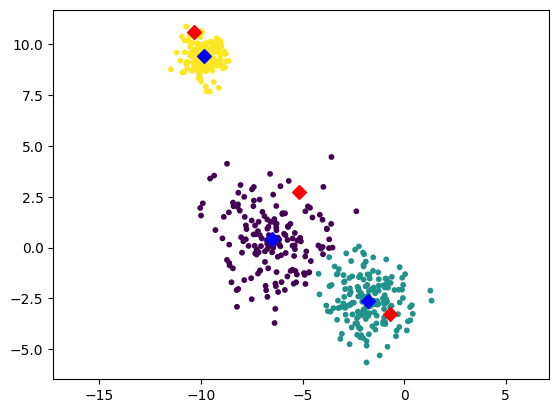

In [36]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D') # initial centroids are in red
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D') # computed centroids are in blue
plt.show()

## Running spectral clustering on the two moons dataset
We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [37]:
dataID, D, labels, r = generateMoons(0.05,n)

In [38]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
# Implement here the computation of W as knn graph
# W = radius_neighbors_graph(D,0.5,include_self=False)
knn_set = [5, 10, 20, 40]
labels_pred = np.zeros(n)
for knn in knn_set:
    W = kneighbors_graph(D,knn,include_self=False)
    Y = spectral_clustering(W,r,init_centroids_greedy_pp)
    for i in range(n):
        labels_pred[i] = np.argmax(Y[i])
    print(f"moons nmi knn={knn}: {metrics.normalized_mutual_info_score(labels, labels_pred)}")

    # plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
    # plt.title('%s'  % ( dataID) )
    # plt.show()

3 iterations
moons nmi knn=5: 0.0034524600208259175
7 iterations
moons nmi knn=10: 0.012645045410236715
10 iterations
moons nmi knn=20: 0.2124966839819454
4 iterations
moons nmi knn=40: 0.5998541615536581
